In [1]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyproj import Geod
import pickle

# Data Import

In [2]:
path = '/glade/work/stevenxu/CESM1'
all_files = glob.glob(os.path.join(path, "*.nc"))
print(all_files) 
datasets = {}
for file in all_files:
    varname = os.path.basename(file).split("_")[0]
    datasets[varname] = xr.open_dataset(file)

['/glade/work/stevenxu/CESM1/PREC_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/ROFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/SHF_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/MELT_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/EVAP_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/IOFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/PD_preindustrial_spinup.nc']


In [55]:
PREC = datasets["PREC"].isel(time=slice(-240,None))
ROFF = datasets["ROFF"].isel(time=slice(-240,None))
SHF  = datasets["SHF"].isel(time=slice(-240,None))
MELT = datasets["MELT"].isel(time=slice(-240,None))
EVAP = datasets["EVAP"].isel(time=slice(-240,None))
IOFF = datasets["IOFF"].isel(time=slice(-240,None))
PD   = datasets["PD"].isel(time=slice(-240,None))

In [56]:
prec = PREC['PREC_F']
roff = ROFF['ROFF_F']
melt = MELT['MELT_F']
evap = EVAP['EVAP_F']
ioff = IOFF['IOFF_F']

# Calculate freshwater flux
FWF = (roff + ioff + melt + prec + evap).rename('FWF')
FWF = FWF.assign_attrs({
    'long_name': 'Total Freshwater Flux',
    'units': 'kg/m^2/s',
    'components': 'ROFF_F + IOFF_F + MELT_F + PREC_F + EVAP_F'
})
FWF = ROFF.assign(FWF=FWF)
FWF = FWF.drop_vars('ROFF_F')

# convert density unit from g/cm^3 to kg/m^3
PD["PD"] = PD["PD"] * 1000.0
PD["PD"].attrs["units"] = "kg/m^3"


In [57]:
density_data = PD
hf_datasets = SHF
wf_datasets = FWF

# Calculate F surf

- Overall mean alpha: 0.00019915005771352584
- Overall mean beta: 0.000746301819876489

In [58]:
def compute_fsurf(
				density_data, hf_datasets, wf_datasets,
				cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
				last_n_months=None):

	HF = hf_datasets['SHF']  # W m^-2, 
	WF = wf_datasets['FWF']     # kg m^-2 s^-1, 
	area = wf_datasets["TAREA"]
	region_mask = hf_datasets["REGION_MASK"]

	rho = density_data['PD']
	alpha = 0.0001391022569339093
	beta = 0.0007600059551595953

	if last_n_months is not None:
		HF  = HF.isel(time=slice(-last_n_months, None))
		WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
	fsurf = (alpha / cp) * HF  +  (rho0 / rho_fw) * beta * S0 * WF
	fsurf = fsurf.assign_attrs(
		long_name="Buoyancy-relevant surface forcing (Eq. 5)",
		description="(alpha/cp)*f_heat + (rho0/rho_fw)*beta*S0*f_water",
		units="",
		cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
	)

	heat_comp = (alpha / cp) * HF
	fw_comp = (rho0 / rho_fw) * beta * S0 * WF

	return xr.Dataset(dict(fsurf=fsurf, rho=rho, heat_comp=heat_comp, fw_comp=fw_comp, area=area, region_mask=region_mask))

Fsurf_data = compute_fsurf(
	density_data = density_data,
	hf_datasets = hf_datasets,
	wf_datasets = wf_datasets,
	last_n_months=240
)

# Drop the z_t coordinate 
Fsurf_data = Fsurf_data.isel(z_t=0).drop_vars('z_t')


Fsurf_data

<xarray.Dataset> Size: 45MB
Dimensions:      (time: 240, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB 325.1 328.7 332.3 ... 320.1 321.5
    ULAT         (nlat, nlon) float64 93kB -78.73 -78.73 -78.73 ... 68.42 68.4
    TLONG        (nlat, nlon) float64 93kB 323.3 326.9 330.5 ... 319.3 320.8
    TLAT         (nlat, nlon) float64 93kB -79.5 -79.5 -79.5 ... 68.26 68.21
Dimensions without coordinates: nlat, nlon
Data variables:
    fsurf        (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    rho          (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    heat_comp    (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    fw_comp      (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    area         (nlat, nlon) float64 93kB ...
    region_mask  (nlat, nlon) float64 93kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

# Calculating Fgen at single timepoint

### Create density class list
Take max and min in rho values, and slice with interval 0.01

In [62]:
ds = Fsurf_data
da = ds['rho'].isel(time=0)
rho_min = float(da.min())
rho_max = float(da.max())

In [63]:
step_size = 0.05
rho_classes = np.arange(rho_min, rho_max + step_size, step_size)

### Dataset for area at each grid cell

In [65]:
area = Fsurf_data["area"]/1e4

### Integration

Group by density intervals and adding up the area-weighted fsurf

Filtering by Lat and region

In [60]:
region_values = [6.0, 8.0, 9.0, 10.0]
Fsurf_data = Fsurf_data.where(Fsurf_data["region_mask"].isin(region_values), drop=True)
Fsurf_data

<xarray.Dataset> Size: 35MB
Dimensions:      (time: 240, nlat: 91, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 73kB 325.1 328.7 332.3 ... 320.0 321.5
    ULAT         (nlat, nlon) float64 73kB -30.71 -30.71 -30.71 ... 68.02 67.99
    TLONG        (nlat, nlon) float64 73kB 323.3 326.9 330.5 ... 319.1 320.7
    TLAT         (nlat, nlon) float64 73kB -32.11 -32.11 -32.11 ... 67.86 67.8
Dimensions without coordinates: nlat, nlon
Data variables:
    fsurf        (time, nlat, nlon) float32 9MB 4.621e-06 5.202e-06 ... nan nan
    rho          (time, nlat, nlon) float32 9MB 1.026e+03 1.025e+03 ... nan nan
    heat_comp    (time, nlat, nlon) float32 9MB 3.972e-06 3.922e-06 ... nan nan
    fw_comp      (time, nlat, nlon) float32 9MB 6.495e-07 1.281e-06 ... nan nan
    area         (nlat, nlon) float64 73kB 1.047e+15 1.047e+15 ... nan nan
    region_mask  (nlat, nlon) float64 73kB 6.0 6.0 6.0 6.0 ... nan nan nan nan

In [66]:
# create a mask to filter by latitude
lat   = Fsurf_data["TLAT"].stack(points=("nlat","nlon"))
mask_pts = lat.where(lat > 45, drop=True).points

# stack or flatten data into 1d array
fsurf = Fsurf_data["fsurf"].stack(points=("nlat","nlon")).sel(points=mask_pts)
rho   = Fsurf_data["rho"].stack(points=("nlat","nlon")).sel(points=mask_pts)
area  = area.stack(points=("nlat","nlon")).sel(points=mask_pts)

# weighted
weighted_fsurf = fsurf * area

# unstack back to original shape
weighted_fsurf = weighted_fsurf.unstack("points")  
rho = rho.unstack("points") 

In [67]:
weighted_fsurf

<xarray.DataArray (time: 240, nlat: 39, nlon: 100)> Size: 7MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * nlat     (nlat) int64 312B 52 53 54 55 56 57 58 59 ... 84 85 86 87 88 89 90
  * nlon     (nlon) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG    (nlat, nlon) float64 31kB nan nan nan nan ... 318.5 320.0 321.5
    ULAT     (nlat, nlon) float64 31kB nan nan nan nan ... 68.09 68.02 67.99
    TLONG    (nlat, nlon) float64 31kB nan nan nan nan ... 317.6 319.1 320.7
    TLAT     (nlat, nlon) float64 31kB nan nan nan nan ... 67.96 67.86 67.8

In [68]:
# Summing up by dentisy interval
Fgen_org = weighted_fsurf.groupby_bins(rho, bins=rho_classes, right=False).sum(dim=("nlat","nlon")) / step_size /1e6

# adding centered coordinate for density intervals
rho_centers = (rho_classes[:-1] + rho_classes[1:]) / 2

# organizing
Fgen = Fgen_org.assign_coords(rho_center=("rho_bins", rho_centers))
Fgen = Fgen.rename(rho_bins="rho_intervals")
Fgen = Fgen.rename('Fgen')
Fgen

<xarray.DataArray 'Fgen' (rho_intervals: 167, time: 240)> Size: 321kB
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [-36.57152701, -30.13009084, -54.29110448, ...,          nan,
                 nan, -10.02234032],
       [-30.94911539, -36.71551787, -46.5917866 , ...,          nan,
                 nan,  -4.93845019],
       [-40.40391537, -49.58289984, -27.03546243, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time           (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
  * rho_intervals  (rho_intervals) int64 1kB 0 1 2 3 4 5 ... 162 163 164 165 166
    rho_center     (rho_intervals) float64 1kB 1.02e+03 1.02e+03 ... 1.028e+03

In [69]:
save_path = f"/glade/work/stevenxu/AMOC_models/CESM1_Fgen.pkl"
with open(save_path, "wb") as f:
    pickle.dump(Fgen, f)

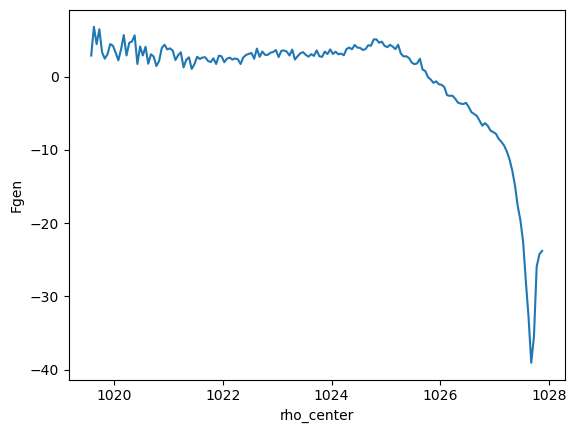

In [72]:
Fgen.mean(dim ='time').plot(x = 'rho_center')